# Интеллектуальная обработка данных

Подключение нужных инструментов

In [2]:
#основные библиотеки
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#ML библиотеки
from sklearn.model_selection import train_test_split
import cv2

import tensorflow as tf
#from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical
#библиотека для обработки аудио
import librosa
import librosa.display
import IPython.display as ipd
#дополнитеьлные инструменты
from tqdm import tqdm
import pylab
from random import random, randrange
import random

### Описание датасета
- 1000 звуковых дорожек
- 10 жанров по 100 треков
- 30 секунд каждая
- моно, 16 бит
- формат: WAV
- от качественных записей до старинных записей с микрофона

In [4]:
#папки, представленные в датасете
DIRS = os.listdir('./data/')
for DIR in DIRS:
    print(DIR)

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


#### Случайный фрагмент из датасета

In [6]:
def random_file(path):
    files_amount = len(os.listdir(path)) - 1
    idx = np.random.randint(files_amount)
    return path + '/' + os.listdir(path)[idx]
def get_random_wav_path():
    random_genre = random_file('./data')
    return random_file(random_genre)

random_wav = get_random_wav_path()
print(random_wav)
audio, sr = librosa.load(random_wav, dtype=np.float32)
audio_length = audio.shape[0] / sr
print(audio_length)
starting_point = round(np.random.uniform(audio_length - 10))
x = audio[starting_point*sr:(starting_point+10)*sr]
ipd.Audio(data=x, rate=sr)

./data/disco/disco.00059.wav
30.00018140589569


#### Визуализация звуковых дорожек разных жанров, можно увидеть, что они сильно отличаются

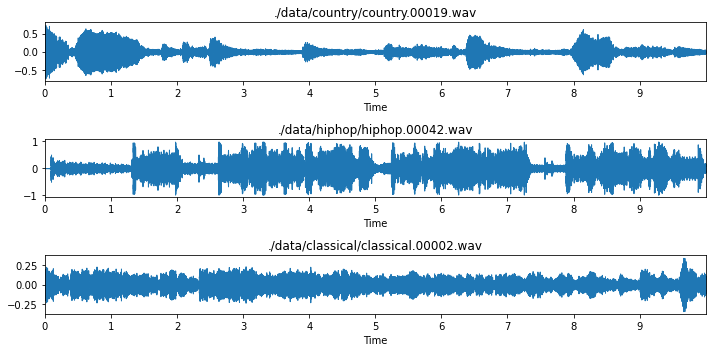

In [62]:
fig = plt.figure(figsize=(10, 5))
for i in range(1, 4):
    random_wav = get_random_wav_path()
    ax = fig.add_subplot(3, 1, i)
    y, sr = librosa.load(random_wav)  
    librosa.display.waveplot(y[:10*sr], sr)
    plt.title(random_wav)
fig.tight_layout()

### Визуализация аудиоинформации в mel-спектрограммы
Mel-спектрограммы - это представление в виде изображения зависимости частоты звукового сигнала от времени, где дополнительная шкала (градиент) - сила звука в децибеллах

In [18]:
def read_wav_file(path, preprocess=True): 
    y, sr = librosa.load(path)
    if preprocess:
        x = y.copy()
        z = y[1:] - 0.97 * x[:-1]
        y = z
        
    signals = []
    for signal_id in range(3):
        signals.append(z[signal_id*sr*10:(signal_id+1)*sr*10])
    return signals, sr


def create_spectrogram(z, sr, save_path):
    pylab.axis('off')
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    S = librosa.feature.melspectrogram(y=z, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
    pylab.close()
    
    
def resize_image(path):    
    SIZE = 224, 224
    im = Image.open(path)
    resized_im = im.resize(SIZE)
    resized_im.save(path)

def full_preprocess(path, save_path):
    y, sr = read_wav_file(path)
    idx = 0
    for signal_id in y:
        save_to = save_path + '_' + str(idx) + '.jpg'
        create_spectrogram(signal_id, sr, save_to)
        resize_image(save_to)
        idx += 1
        
def prepare_dataset(path='./', path_for_mels='mels'):
    if path_for_mels not in os.listdir():
        os.mkdir(path + path_for_mels)
    
    genres = os.listdir(path + '/data')
    for genre in genres:
        if genre not in os.listdir(path + path_for_mels):
            os.mkdir(path + path_for_mels + '/' + genre)
        audios = os.listdir(path + '/data/' + genre)
        audios_amount = len(audios)
        id_audio = 0
        for id_audio in tqdm(range(audios_amount)):
            folder = path + path_for_mels + '/'
            full_preprocess(path + '/data/' + genre + '/' + audios[id_audio], \
                           folder + genre + '/' + audios[id_audio][:-4])

In [19]:
prepare_dataset()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


#### Результат обработки 

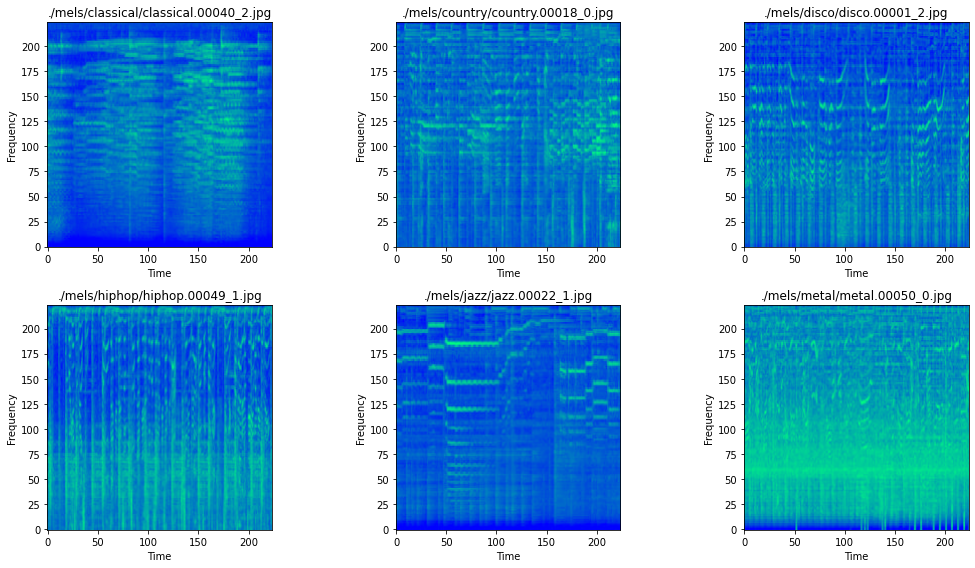

In [57]:
fig = plt.figure(figsize=(15, 8))
for i in range(1, 7):
    genre = './mels/' + DIRS[i]
    random_mel = random_file(genre), genre[7:]
    ax = fig.add_subplot(2, 3, i)
    im = cv2.imread(random_mel[0], cv2.IMREAD_GRAYSCALE)
    plt.title(random_mel[0])
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.imshow(im, cmap='winter', aspect='equal', origin="lower")
fig.tight_layout()